In [114]:
%reset -f

In [115]:
import numpy as np
import pandas as pd
import os
import itertools
import matplotlib.pyplot as plt
import ast
import pdb
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import seaborn as sns
import random
from torchsummary import summary
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader, sampler
from torch.nn.utils.rnn import pad_sequence
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import confusion_matrix
from torch import linalg
from ete3 import Tree
from datetime import date

seed = 0
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

# Data
## Load the fish tree of life

In [116]:
fish_tree_path = '/home/theophile/data/fish_tree_of_life/actinopt_12k_raxml.tre'
fish_tree = Tree(fish_tree_path)

## Load data processed with obitools
These data have been processed by Benjamin with obitools.

In [117]:
species_file = '/data/shared/code_v01/data/v4_species.csv'
taxa_file = '/data/shared/code_v01/data/ref_taxid_v4.fasta'
genus_file = '/data/shared/code_v01/data/v4_genus.csv'
genus_taxid_file = '/data/shared/code_v01/evaluation/rank_correlation/v4_genus_taxid.fasta'
nn_raw_data_folder = '/data/shared/code_v01/evaluation/nn_raw/'
obitools_data_folder = '/data/shared/FW_FrenchGuyana_201x/results_obitools'
obitools_files = os.listdir(obitools_data_folder)

In [118]:
# from Benjamin's code
def load_obitools_data(species_file, genus_file, obitools_data_folder):
    # species taxids
    species = pd.read_csv(species_file, sep=';')
    species = species.set_index('species')
    species['taxid'] = -1
    species.sort_values('species_cat', inplace=True)
    species.drop(columns='species_cat', inplace=True)
    with open(taxa_file) as fasta:
        for line in fasta.readlines():
            if line.startswith('>'):
                # >662Fl-15-065 species_name=Bryconops caudomaculatus; taxid=1463024;
                li = line.strip().split(' ', 1)[1]
                li = li.split(';')
                sp = li[0].strip().split('=')
                tid = li[1].strip().split('=')
                species.loc[sp[1], 'taxid'] = int(tid[1])

    # genus taxids
    genus = pd.read_csv(genus_file, sep=';')
    genus = genus.set_index('genus')
    genus['taxid'] = -1
    genus.sort_index(inplace=True)
    with open(genus_taxid_file) as fasta:
        for line in fasta.readlines():
            if line.startswith('>'):
                # >155 taxid=106210; genus_name=Pseudotylosurus;
                li = line.strip().split(' ', 1)[1]
                li = li.split(';')
                tid = li[0].strip().split('=')
                ge = li[1].strip().split('=')
                genus.loc[ge[1], 'taxid'] = int(tid[1])

    # 368 species in total
    species = pd.concat([species, genus])

    obitools = species.copy()
    all_df = {}
    for file in os.listdir(obitools_data_folder):
        df = pd.read_csv(os.path.join(obitools_data_folder, file), sep='\t')
        cols = [
            i for i in df.columns.to_list() if i == 'species_list:ref_taxid'
            or i == 'taxid_by_db:ref_taxid' or i == 'sequence'
        ]
        #cols = [n for n in df.columns.to_list() if not n.startswith('sample')]
        df = df[cols]
        all_df[file] = df
    obitools_data = pd.concat(all_df)
    #obitools = obitools.astype('int64')
    #obitools.columns = [ i[7:] if i.startswith('sample:') else i for i in obitools.columns]
    return obitools_data

In [119]:
obitools_data = load_obitools_data(species_file, genus_file,
                                   obitools_data_folder)
print(len(obitools_data))
print(len(obitools_data['sequence'].unique()))
print(len(obitools_data['taxid_by_db:ref_taxid'].unique()))

112282
66126
420


Associate sequence to species list

Sequences without species associated: 6231 over 66126


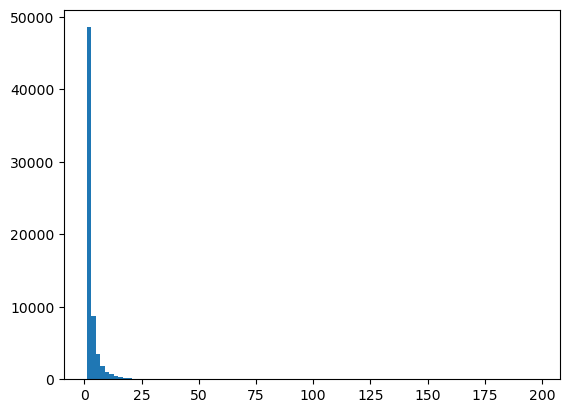

In [120]:
grouped_obitools_data = obitools_data.groupby('sequence')
dataset_species = {}
for sequence, group in grouped_obitools_data:
    species = [
        species_sublist.strip("]''[").split("', '")
        for species_sublist in group['species_list:ref_taxid'].to_list()
    ]
    dataset_species[sequence] = list(itertools.chain.from_iterable(species))

plt.hist([len(dataset_species[seq]) for seq in dataset_species.keys()],
         bins=100)
plt.plot()
i = 0
for k in dataset_species.keys():
    if all(len(species) == 0 for species in dataset_species[k]):
        i += 1
print(f'Sequences without species associated: {i} over {len(dataset_species)}')

Associate sequence to species list with at least one species

In [121]:
def convert_to_species_dict(obitools_data):
    grouped_obitools_data = obitools_data.groupby('sequence')
    dataset_species = {}
    for sequence, group in grouped_obitools_data:
        species = [
            species_sublist.strip("]''[").split("', '")
            for species_sublist in group['species_list:ref_taxid'].to_list()
        ]
        species_list = list(itertools.chain.from_iterable(species))
        species_list = list(filter(None, species_list))
        if len(species_list) > 0:
            dataset_species[sequence] = species_list
    return dataset_species

In [122]:
dataset_species = convert_to_species_dict(obitools_data)
len(dataset_species)

59895

In [123]:
def convert_to_sequences_dict(obitools_data, unique=False):
    dataset_species = convert_to_species_dict(obitools_data)
    dataset_sequences = {}
    for seq, species in dataset_species.items():
        for spe in species:
            dataset_sequences.setdefault(spe, []).append(seq)
    if unique:
        for spe in dataset_sequences.keys():
            dataset_sequences[spe] = list(np.unique(dataset_sequences[spe]))
    return dataset_sequences


dataset_sequences = convert_to_sequences_dict(obitools_data, True)

Species and class imbalance

In [124]:
all_species = list(
    itertools.chain.from_iterable(
        [dataset_species[seq] for seq in dataset_species]))
print(
    f'{len(np.unique(np.array(all_species)))} unique species over {len(all_species)} listed'
)


364 unique species over 168370 listed


290.41483516483515


[]

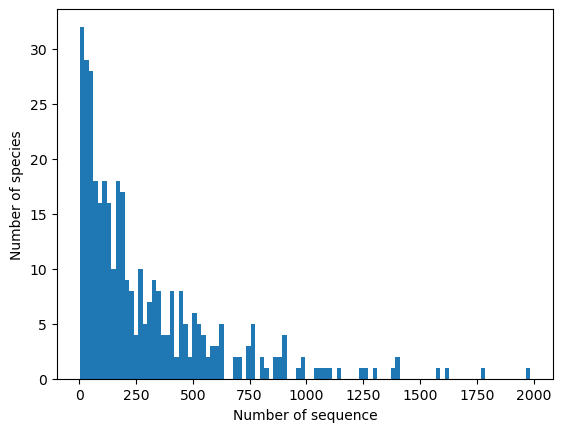

In [125]:
plt.hist(
    [len(dataset_sequences[species]) for species in dataset_sequences.keys()],
    bins=100)
plt.xlabel('Number of sequence')
plt.ylabel('Number of species')

print(np.mean([len(dataset_sequences[species]) for species in dataset_sequences.keys()]))
plt.savefig('nb_sequence.pdf')
plt.plot()

Sequence lengths distribution

131


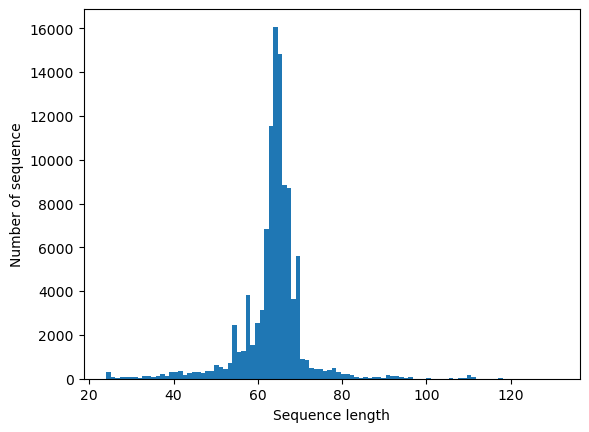

In [126]:
plt.hist([
    len(seq) for k in dataset_sequences.keys() for seq in dataset_sequences[k]
],
         bins=100)
plt.xlabel('Sequence length')
plt.ylabel('Number of sequence')
print(
    max([
        len(seq) for k in dataset_sequences.keys()
        for seq in dataset_sequences[k]
    ]))
plt.savefig('sequence_length.pdf')
plt.show()

In [127]:
print(f'number of species: {len([k for k in dataset_sequences])}')
print(f'number of sequence: {sum([len(dataset_sequences[k]) for k in dataset_sequences])}')
seq_lengths = [len(seq) for k in dataset_sequences.keys() for seq in dataset_sequences[k]]
print(f'sequence lengths: mean {np.mean(seq_lengths):.2f}, std {np.std(seq_lengths):.2f}')


number of species: 364
number of sequence: 105711
sequence lengths: mean 63.58, std 7.88


## Data loader

In [128]:
def encode_dna_sequence_to_one_hot(dna_sequence):
    IUPAC_code = {
        'A': [1, 0, 0, 0],
        'C': [0, 1, 0, 0],
        'G': [0, 0, 1, 0],
        'T': [0, 0, 0, 1],
        'U': [None, None, None, None],
        'R': [0.5, 0, 0.5, 0],
        'Y': [0, 0.5, 0, 0.5],
        'M': [0.5, 0.5, 0, 0],
        'K': [0, 0, 0.5, 0.5],
        'S': [0, 0.5, 0.5, 0],
        'W': [0.5, 0, 0, 0.5],
        'H': [1 / 3, 1 / 3, 0, 1 / 3],
        'B': [0, 1 / 3, 1 / 3, 1 / 3],
        'V': [1 / 3, 1 / 3, 1 / 3, 0],
        'D': [1 / 3, 0, 1 / 3, 1 / 3],
        'N': [0.25, 0.25, 0.25, 0.25]
    }
    return torch.Tensor([IUPAC_code[n.upper()] for n in dna_sequence])


def encode_one_hot(index, length):
    one_hot_vec = torch.zeros(length)
    one_hot_vec[index] = 1

    return one_hot_vec


def convert_tree_to_distance_matrix(tree, species_names):
    #leaf_names = [leaf.name for leaf in tree.iter_leaves()]
    num_leaves = len(species_names)
    pairwise_distances = np.zeros((num_leaves, num_leaves))

    for i in range(num_leaves):
        for j in range(i + 1, num_leaves):
            distance = tree.get_distance(species_names[i], species_names[j])
            pairwise_distances[i, j] = distance
            pairwise_distances[j, i] = distance
    return pairwise_distances


class ObitoolsDataset(Dataset):

    def __init__(self,
                 species_file,
                 genus_file,
                 obitools_data_folder,
                 unseen_species_proportion=0.,
                 pad_sequence=False,
                 fish_tree=None):
        obitools_data = load_obitools_data(species_file, genus_file,
                                           obitools_data_folder)
        self.dataset_sequences = convert_to_sequences_dict(obitools_data,
                                                           unique=True)
        self.species_names = list(self.dataset_sequences.keys())
        if fish_tree is not None:
            self.fish_tree = fish_tree.copy()
            fish_tree_leaf_names = [
                leaf.name.replace('_', ' ')
                for leaf in fish_tree.iter_leaves()
            ]
            self.dataset_sequences = {
                species: self.dataset_sequences[species]
                for species in self.species_names
                if species in fish_tree_leaf_names
            }
            intersect = np.intersect1d(fish_tree_leaf_names,
                                       self.species_names)
            intersect = np.sort(intersect)
            intersect = [
                str(species).replace(' ', '_') for species in intersect
            ]
            self.fish_tree.prune(intersect)
            self.phylo_distance_matrix = torch.Tensor(
                convert_tree_to_distance_matrix(self.fish_tree, intersect))
            intersect = [
                str(species).replace('_', ' ') for species in intersect
            ]
            self.species_names = intersect
        self.n_species = len(self.dataset_sequences.keys())
        self.species_names_one_hot = {
            species: encode_one_hot(index, self.n_species)
            for index, species in enumerate(self.species_names)
        }
        self.n_sequences = sum([
            len(self.dataset_sequences[species])
            for species in self.dataset_sequences.keys()
        ])
        self.species_unseen = np.random.choice(
            [True, False],
            self.n_species,
            p=(unseen_species_proportion, 1 - unseen_species_proportion))
        self.dataset = [[
            self.species_names_one_hot[species],
            encode_dna_sequence_to_one_hot(seq)
        ] for species in self.dataset_sequences.keys()
                        for seq in self.dataset_sequences[species]]
        self.unseen = [
            True if species in np.array(list(
                self.dataset_sequences.keys()))[self.species_unseen] else False
            for species in self.dataset_sequences.keys()
            for seq in self.dataset_sequences[species]
        ]
        self.max_seq_len = max([seq[1].shape[0] for seq in self.dataset])
        if pad_sequence:
            for e in self.dataset:
                e[1] = F.pad(e[1], (0, 0, 0, self.max_seq_len - e[1].shape[0]),
                             "constant", 0)

    def __getitem__(self, index, unseen_classes=False):
        if unseen_classes and self.unseen[index]:
            return torch.zeros(self.n_species), self.dataset[index][1]
        else:
            return self.dataset[index][0], self.dataset[index][1]

    def __len__(self):
        return self.n_sequences


def collate_with_padding(batch):
    species_one_hot, seq = zip(*batch)
    seq_padded = pad_sequence(seq, batch_first=True, padding_value=0)
    return torch.stack(species_one_hot), seq_padded


In [129]:
unseen_species_proportion = 0.15
batch_size = 300
num_workers = 7

data = ObitoolsDataset(species_file,
                       genus_file,
                       obitools_data_folder,
                       unseen_species_proportion=unseen_species_proportion,
                       pad_sequence=True,
                       fish_tree=fish_tree)

if unseen_species_proportion > 0:
    training_indices = np.argwhere(np.array(data.unseen) == False)[:, 0]
    validation_indices = np.argwhere(np.array(data.unseen))[:, 0]

else:
    proportion_train = 0.90
    train_length = int(len(data) * proportion_train)
    validation_length = int(len(data) - train_length)
    training_indices, validation_indices = torch.utils.data.random_split(
        list(range(len(data))), [train_length, validation_length])  #,
    #generator=torch.Generator().manual_seed(seed))
#something wrong here - not anymore?

train_sampler = sampler.SubsetRandomSampler(list(training_indices))
validation_sampler = sampler.SubsetRandomSampler(list(validation_indices))

train_loader = DataLoader(data,
                          sampler=train_sampler,
                          batch_size=batch_size,
                          drop_last=False,
                          num_workers=num_workers)

validation_loader = DataLoader(data,
                               sampler=validation_sampler,
                               batch_size=batch_size,
                               drop_last=False,
                               num_workers=num_workers)

print(
    f'There is {len(train_sampler)} training data and {len(validation_sampler)} validation data.'
)
print(
    f'{sum(data.species_unseen)} out of {len(data.species_unseen)} species are absent from the training data.'
)


There is 27673 training data and 6937 validation data.
28 out of 133 species are absent from the training data.


In [130]:
'''def compute_accuracy(targets, predictions):
    targets = torch.argmax(torch.cat(targets).cpu(), dim=1)
    predictions = torch.argmax(torch.cat(predictions).cpu(), dim=1)
    cm = confusion_matrix(targets, predictions)

    return np.trace(cm) / np.sum(cm)


def compute_topk_accuracy(targets, predictions, k):
    targets = np.array(torch.argmax(torch.cat(targets).cpu(), dim=1))
    predictions = np.array(
        torch.topk(torch.cat(predictions).cpu(), k, dim=1).indices)
    accuracy = [
        targets[index] in predictions[index] for index in range(len(targets))
    ]

    return sum(accuracy) / len(accuracy)'''

def compute_accuracy(targets, predictions, k):
    targets = np.array(torch.argmax(targets, dim=1).cpu())
    predictions = np.array(
        torch.topk(predictions, k, dim=1).indices.cpu())
    accuracy = [
        targets[index] in predictions[index] for index in range(len(targets))
    ]

    return sum(accuracy) / len(accuracy)

def init_weights(module):
    if isinstance(module, nn.Conv2d) or isinstance(
            module, nn.Conv1d) or isinstance(module, nn.Linear):
        #nn.init.xavier_normal_(module.weight, gain=nn.init.calculate_gain('relu'))
        nn.init.kaiming_normal_(module.weight, nonlinearity='relu')
    elif isinstance(module, nn.ModuleList):
        for sub_module in module:
            init_weights(sub_module)


## Model definition

In [131]:
class DNAiBlock(nn.Module):

    def __init__(self, n_features_in, n_features_out):
        super(DNAiBlock, self).__init__()
        self.conv = nn.Conv2d(n_features_in,
                              n_features_out, (1, 3),
                              padding='same')
        self.batch_norm = nn.BatchNorm2d(n_features_in)

    def forward(self, x):
        x = self.batch_norm(x)
        x = self.conv(x.clone())
        x = F.relu(x)

        return x


class DNAiNet(nn.Module):

    def __init__(self, n_features, n_species, max_seq_len, n_blocks=15):
        super(DNAiNet, self).__init__()
        self.conv = nn.Conv2d(1, n_features, (3, 4))
        self.batch_norm = nn.BatchNorm2d(n_features)
        self.dnai_blocks = nn.ModuleList(
            [DNAiBlock(n_features) for i in range(n_blocks)])
        self.pool_kernel = 2
        self.pool = nn.AvgPool1d(self.pool_kernel)
        self.last_batch_norm1 = nn.BatchNorm1d(
            n_features * ((max_seq_len - 2) // self.pool_kernel))
        self.last_linear_layer1 = nn.Linear(
            n_features * ((max_seq_len - 2) // self.pool_kernel), n_species)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.conv(x)
        x = self.batch_norm(x)
        x = F.relu(x)
        for i, block in enumerate(self.dnai_blocks):
            x = block(x)
        x = x.squeeze(3)
        x = self.pool(x)
        x = torch.flatten(x, start_dim=1)
        x = self.last_batch_norm1(x)
        x = self.last_linear_layer1(x)
        x = self.sigmoid(x)

        return x


class ArcFace(nn.Module):

    def __init__(self, cin, cout, s, m):
        super().__init__()
        self.s = s
        self.sin_m = torch.sin(torch.tensor(m))
        self.cos_m = torch.cos(torch.tensor(m))
        self.cout = cout
        self.fc = nn.Linear(cin, cout, bias=False)

    def forward(self, x, label=None):
        w_norm = linalg.norm(self.fc.weight.detach(), dim=1, keepdim=True).T
        x_norm = linalg.norm(x, dim=1, keepdim=True)
        cos = self.fc(x) / (x_norm * w_norm)

        if label is not None:
            sin_m, cos_m = self.sin_m, self.cos_m
            one_hot = label  #F.one_hot(label, num_classes=self.cout)
            sin = (1 - cos**2)**0.5
            angle_sum = cos * cos_m - sin * sin_m
            cos = angle_sum * one_hot + cos * (1 - one_hot)
            cos = cos * self.s

        return cos


class DNAiNetArcface(nn.Module):

    def __init__(self, n_features, n_species, max_seq_len, n_blocks=15):
        super(DNAiNetArcface, self).__init__()
        self.conv = nn.Conv2d(1, n_features, (3, 4))
        self.batch_norm = nn.BatchNorm2d(n_features)
        self.dnai_blocks = nn.ModuleList([
            DNAiBlock(n_features // (i + 1), n_features // (i + 2))
            for i in range(n_blocks)
        ])
        self.pool_kernel = 2
        self.pool = nn.AvgPool1d(self.pool_kernel)
        out_shape = (n_features // (n_blocks - 1 + 2)) * (
            (max_seq_len - 2) // self.pool_kernel)
        self.last_batch_norm1 = nn.BatchNorm1d(out_shape)
        self.last_linear_layer1 = nn.Linear(out_shape, n_species)
        s = np.sqrt(2) * np.log(n_species - 1)  # From fixed Adacos
        self.arcface = ArcFace(n_species, n_species, s=s, m=0.25)

    def forward(self, x, label=None):
        x = x.unsqueeze(1)
        x = self.conv(x)
        x = self.batch_norm(x)
        x = F.relu(x)
        for i, block in enumerate(self.dnai_blocks):
            x = block(x)
        x = x.squeeze(3)
        x = self.pool(x)
        x = torch.flatten(x, start_dim=1)
        x = self.last_batch_norm1(x)
        x = self.last_linear_layer1(x)
        x = self.arcface(x, label)

        return x

## Training

In [132]:
class MultitaskLoss(nn.Module):
    def __init__(self, model, phylo_distance_matrix):
        super(MultitaskLoss, self).__init__()
        self.model = model
        self.similarity_matrix = 1 - phylo_distance_matrix
        self.classification_criterion = nn.CrossEntropyLoss()
        self.log_variances = nn.Parameter(torch.rand(2))
        self.phylo_criterion = nn.MSELoss()

    def forward(self, inputs, targets=None):
        outputs = self.model(inputs, targets)
        phylo_loss = self.phylo_loss()
        
        if targets != None and self.training:
            classification_loss = self.classification_criterion(outputs, targets)
            precisions = torch.exp(-self.log_variances)
            multitask_loss = precisions[0] * classification_loss + self.log_variances[0] + 1 / 2 * precisions[1] * phylo_loss + self.log_variances[1]

            return multitask_loss, classification_loss, phylo_loss, outputs

        elif targets == None and not self.training:
            return phylo_loss, outputs
            
    def cosine_similarity(self, M):
        M_norm = M / M.norm(dim=1).unsqueeze(1)
        return torch.mm(M_norm, M_norm.T)

    def phylo_loss(self):
        phylo_loss = self.phylo_criterion(
            self.cosine_similarity(self.model.arcface.fc.weight),
            self.similarity_matrix)
        
        return phylo_loss

In [133]:
n_epochs = 300
top_k = 5
lr = 0.0005
patience = 50
n_blocks = 6
n_features = 2**9

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

net = DNAiNetArcface(n_features,
                     data.n_species,
                     data.max_seq_len,
                     n_blocks=n_blocks)

multitask_criterion = MultitaskLoss(net, data.phylo_distance_matrix.to(device))

net.apply(init_weights)

#print(f'Number of trainable parameters:', sum(p.numel() for p in net.parameters() if p.requires_grad))
summary(net)
            
if device.type == 'cuda':
    multitask_criterion = multitask_criterion.to(device)
#    multitask_criterion = torch.nn.DataParallel(multitask_criterion,
#                                device_ids=range(torch.cuda.device_count()))

optimizer = optim.Adam(multitask_criterion.parameters(), lr=lr)
scheduler = ReduceLROnPlateau(optimizer, factor=0.5, patience=patience)
best_validation_loss = float('inf')
log_dict = {
    'training_loss': [],
    'training_classification_loss': [],
    'training_phylo_loss': [],
    'training_accuracy': [],
    'validation_accuracy': [],
    'phylo_loss': [],
    f'training_accuracy_top{top_k}': [],
    f'validation_accuracy_top{top_k}': []
}

for e in range(n_epochs):
    print(f'Epoch: {e}')
    with torch.no_grad():
        phylo_loss = multitask_criterion.phylo_loss()
        print(f'Phylogenetic loss: {phylo_loss}')
        log_dict['phylo_loss'].append(float(phylo_loss))

    multitask_criterion.train()
    running_training_loss = 0
    running_training_classification_loss = 0
    running_training_phylo_loss = 0
    running_training_accuracy = 0
    running_training_accuracy_topk = 0
    training_data_len = 0

    for i, (species_training, edna_training) in enumerate(train_loader):
        edna_training = edna_training.to(device)
        effective_batch_size = edna_training.size(0)
        training_data_len += effective_batch_size
        species_training = species_training.to(device)
        multitask_loss, classification_loss, phylo_loss, output_training = multitask_criterion(edna_training, species_training)

        multitask_loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        running_training_loss += multitask_loss.item() * effective_batch_size
        running_training_classification_loss += classification_loss.item() * effective_batch_size
        running_training_phylo_loss += phylo_loss.item() * effective_batch_size
        running_training_accuracy += compute_accuracy(species_training, output_training, 1) * effective_batch_size
        running_training_accuracy_topk += compute_accuracy(species_training, output_training, top_k) * effective_batch_size

    log_dict['training_loss'].append(running_training_loss / training_data_len)
    log_dict['training_classification_loss'].append(running_training_classification_loss / training_data_len)
    log_dict['training_phylo_loss'].append(running_training_phylo_loss / training_data_len)
    log_dict['training_accuracy'].append(running_training_accuracy / training_data_len)
    log_dict[f'training_accuracy_top{top_k}'].append(running_training_accuracy_topk / training_data_len)
    print(f'Training loss: {log_dict["training_loss"][-1]:.3f}')
    print(f'Training accuray: {log_dict["training_accuracy"][-1]:.3f}')
    print(
        f'Top-{top_k} training accuray: {log_dict[f"training_accuracy_top{top_k}"][-1]:.3f}'
    )

    multitask_criterion.eval()
    with torch.no_grad():
        running_validation_accuracy = 0
        running_validation_accuracy_topk = 0
        validation_data_len = 0

        for i, (species_validation,
                edna_validation) in enumerate(validation_loader):
            edna_validation = edna_validation.to(device)
            effective_batch_size = edna_validation.size(0)
            validation_data_len += effective_batch_size
            species_validation = species_validation.to(device)
            phylo_loss, output_validation = multitask_criterion(edna_validation)
            running_validation_accuracy += compute_accuracy(species_validation, output_validation, 1) * effective_batch_size
            running_validation_accuracy_topk += compute_accuracy(species_validation, output_validation, top_k) * effective_batch_size

    log_dict['validation_accuracy'].append(running_validation_accuracy / validation_data_len)
    log_dict[f'validation_accuracy_top{top_k}'].append(running_validation_accuracy_topk / validation_data_len)
    print(f'Validation accuray: {log_dict["validation_accuracy"][-1]:.3f}')
    print(
        f'Top-{top_k} validation accuray: {log_dict[f"validation_accuracy_top{top_k}"][-1]:.3f}'
    )
    print(f'Learning rate: {optimizer.param_groups[0]["lr"]}\n')
    scheduler.step(log_dict['training_loss'][-1])

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            6,656
├─BatchNorm2d: 1-2                       1,024
├─ModuleList: 1-3                        --
|    └─DNAiBlock: 2-1                    --
|    |    └─Conv2d: 3-1                  393,472
|    |    └─BatchNorm2d: 3-2             1,024
|    └─DNAiBlock: 2-2                    --
|    |    └─Conv2d: 3-3                  130,730
|    |    └─BatchNorm2d: 3-4             512
|    └─DNAiBlock: 2-3                    --
|    |    └─Conv2d: 3-5                  65,408
|    |    └─BatchNorm2d: 3-6             340
|    └─DNAiBlock: 2-4                    --
|    |    └─Conv2d: 3-7                  39,270
|    |    └─BatchNorm2d: 3-8             256
|    └─DNAiBlock: 2-5                    --
|    |    └─Conv2d: 3-9                  26,095
|    |    └─BatchNorm2d: 3-10            204
|    └─DNAiBlock: 2-6                    --
|    |    └─Conv2d: 3-11                 18,688
|    |    └─BatchNorm2d: 3-12   

In [134]:
def save_run():
    today = date.today()
    directory = f'run/run_{today.strftime("%b_%d_%Y")}_seed_{seed}_n_blocks_{n_blocks}'
    save_format = 'pdf'

    if not os.path.exists(directory):
        os.makedirs(directory)

    sns.lineplot(log_dict['phylo_loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Phylogenetic loss')
    plt.savefig(os.path.join(directory, f'phylo_loss.{save_format}'))
    plt.show()

    sns.lineplot(torch.Tensor(log_dict['training_phylo_loss']), label='phylogenetic loss')
    sns.lineplot(torch.Tensor(log_dict['training_loss']), label='multitask loss')
    sns.lineplot(torch.Tensor(log_dict['training_classification_loss']), label='classification loss')
    
    plt.xlabel('Epoch')
    plt.ylabel('Training loss')
    plt.savefig(os.path.join(directory, f'training_loss.{save_format}'))
    plt.show()

    sns.lineplot(torch.Tensor(log_dict['training_accuracy']),
                 label='training top-1')
    sns.lineplot(torch.Tensor(log_dict[f'training_accuracy_top{top_k}']),
                 label=f'training top-{top_k}')
    sns.lineplot(torch.Tensor(log_dict['validation_accuracy']),
                 label='validation top-1')
    sns.lineplot(torch.Tensor(log_dict[f'validation_accuracy_top{top_k}']),
                 label=f'validation top-{top_k}',
                 alpha=0.5)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim((0, 1))
    plt.savefig(os.path.join(directory, f'accuracy.{save_format}'))
    plt.show()

    with open(os.path.join(directory, 'metadata.txt'), 'w') as f:
        f.write(
            f'Seed: {seed}\nNumber of epochs: {n_epochs}\nLearning rate: {lr}\nPatience: {patience}\nUnseen species proportion: {unseen_species_proportion}\nBatch size:{batch_size}\nNumber of features:{n_features}\nNumber of blocks: {n_blocks}'
        )
        f.write(
            f'There is {len(train_sampler)} training data and {len(validation_sampler)} validation data.'
        )
        f.write(
            f'{sum(data.species_unseen)} out of {len(data.species_unseen)} species are absent from the training data.'
        )
        f.write(
            f'Best validation top-1 accuracy: {max(log_dict["validation_accuracy"])}'
        )
        f.write(
            f'Best validation top-{top_k} accuracy: {max(log_dict[f"validation_accuracy_top{top_k}"])}'
        )
    print(
        f'Best validation top-1 accuracy: {max(log_dict["validation_accuracy"])}'
    )
    print(
        f'Best validation top-{top_k} accuracy: {max(log_dict[f"validation_accuracy_top{top_k}"])}'
    )


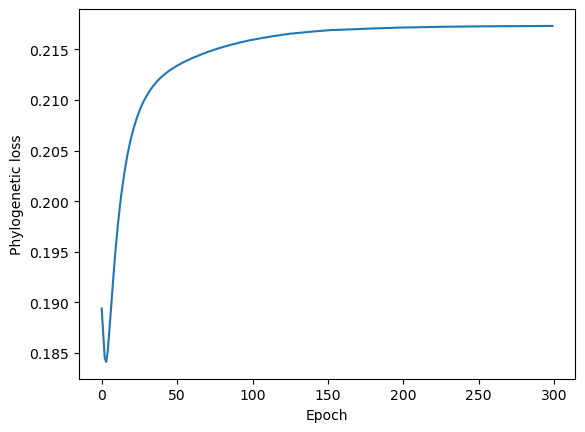

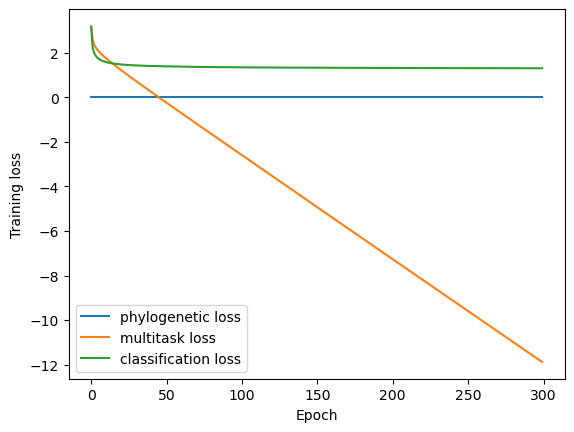

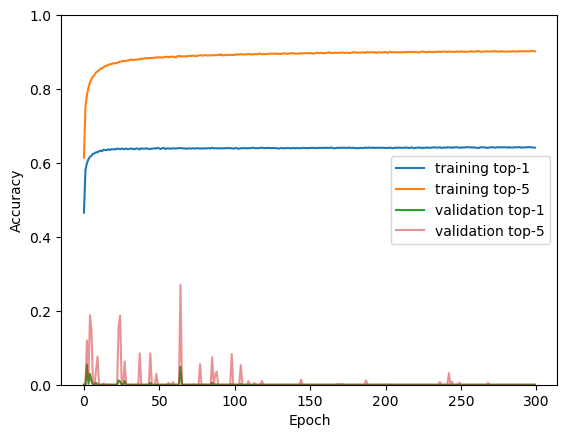

Best validation top-1 accuracy: 0.0536254865215511
Best validation top-5 accuracy: 0.27057805967997695


In [135]:
save_run()

In [136]:
multitask_criterion.log_variances

Parameter containing:
tensor([  0.2717, -13.1728], device='cuda:0', requires_grad=True)

In [137]:
multitask_criterion.log_variances

Parameter containing:
tensor([  0.2717, -13.1728], device='cuda:0', requires_grad=True)